# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

## EP2: Regressão Linear na Base "California Housing"

## Autor: Rodrigo Gebara Reis

# 1. Introdução:

Nesse EP, vamos criar um modelo que prediz o preço médio de uma casa em uma região da Califórnia. O objetivo é testar os regressores lineares vistos até agora em aula: KNN, LASSO e RIDGE.

# 2. Importação das bibliotecas:

Vamos fazer a importação das bibliotecas pertinentes: pandas, matplotlib e seaborn para análise dos dados e criação de gráficos; numpy para algumas operações matemáticas; sklearn para os regressores propriamente ditos e geopy para cálculo de distâncias a partir de coordenadas geográficas:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from geopy.distance import distance, geodesic

# 3. Análise da base de dados:

## 3.1. Leitura dos dados:

Vamos importar as bases de treino e teste, respectivamente:

In [2]:
train = pd.read_csv("../input/atividade-regressao-PMR3508/train.csv")
test = pd.read_csv("../input/atividade-regressao-PMR3508/test.csv")

## 3.2. Tratamento inicial dos dados:

Agora vamos visualizar as primeiras linhas do dataframe de treino, para conhecer seus atributos. Além disso, devemos conferir seu tamanho:

In [3]:
train.head()

,Id,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,15817,-120.85,37.57,27,819,157,451,150,34934,193800
1,6236,-117.74,34.06,48,2438,599,1508,548,28983,129200
2,19262,-118.11,33.92,32,1016,190,729,177,43000,151300
3,19743,-118.12,34.15,35,1760,447,984,384,34167,198200
4,7272,-120.63,37.41,27,2083,444,1462,479,26439,69100


In [4]:
train.shape

(14448, 10)

Realizando o mesmo procedimento para os dados de teste:

In [5]:
test.head()

,Id,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income
0,8609,-118.67,34.30,5,6123,825,2440,736,79013
1,14610,-117.66,34.09,26,1151,200,593,188,36667
2,1557,-118.93,35.37,34,2412,446,1558,421,26903
3,12875,-117.23,34.14,16,2577,521,956,472,25625
4,17821,-121.06,38.98,14,2267,355,1140,369,47019


In [6]:
test.shape

(6192, 9)

Em nosso dataset, temos os seguintes atributos:

$\bullet$ Id - Identificação dos locais

$\bullet$ latitude: Latitude do local (em graus)

$\bullet$ longitude: Longitude do local

$\bullet$ median_age: Mediana das idades dos imóveis no local

$\bullet$ total_rooms: Contagem do número de cômodos das casas na região

$\bullet$ total_bedrooms: Contagem do total de quartos das casas na região

$\bullet$ population: População na região

$\bullet$ households: Número total de casas na região

$\bullet$ median_income: Mediana da renda das pessoas na região

$\bullet$ median_house_value: Variável Target.

Note que a coluna "Id" serve apenas para indexação. Assim, ele será removido de ambos os datasets. No entanto, vamos armazenar a ordem do arquivo de teste para fazer a submissão posteriormente:

In [7]:
train = train.drop("Id", axis = 1)
testId = test.Id
test = test.drop("Id", axis = 1)

In [8]:
train.head()

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-120.85,37.57,27,819,157,451,150,34934,193800
1,-117.74,34.06,48,2438,599,1508,548,28983,129200
2,-118.11,33.92,32,1016,190,729,177,43000,151300
3,-118.12,34.15,35,1760,447,984,384,34167,198200
4,-120.63,37.41,27,2083,444,1462,479,26439,69100


In [9]:
test.head()

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income
0,-118.67,34.30,5,6123,825,2440,736,79013
1,-117.66,34.09,26,1151,200,593,188,36667
2,-118.93,35.37,34,2412,446,1558,421,26903
3,-117.23,34.14,16,2577,521,956,472,25625
4,-121.06,38.98,14,2267,355,1140,369,47019


Realizando uma análise quantitativa inicial dos dados de treino:

In [10]:
train.describe()

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,-119.563050,35.625804,28.700028,2622.627284,535.628391,1413.978405,496.934109,38747.577450,207556.603267
std,2.008096,2.138690,12.587508,2145.423570,416.800426,1095.060629,376.873380,19091.513037,116441.436255
min,-124.350000,32.550000,1.000000,2.000000,2.000000,3.000000,2.000000,4999.000000,14999.000000
25%,-121.790000,33.930000,18.000000,1444.000000,295.000000,784.000000,279.000000,25596.500000,119300.000000
50%,-118.490000,34.250000,29.000000,2116.000000,432.000000,1160.000000,407.000000,35334.000000,179950.000000
75%,-118.000000,37.710000,37.000000,3131.250000,645.250000,1705.000000,602.000000,47500.000000,266100.000000
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,150001.000000,500001.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   median_age          14448 non-null  int64  
 3   total_rooms         14448 non-null  int64  
 4   total_bedrooms      14448 non-null  int64  
 5   population          14448 non-null  int64  
 6   households          14448 non-null  int64  
 7   median_income       14448 non-null  int64  
 8   median_house_value  14448 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 1016.0 KB


In [12]:
train.isnull().sum()

longitude             0
latitude              0
median_age            0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

Note que não há dados faltantes na base de dados, o que deve proporcionar uma análise mais precisa.

O mesmo ocorre com os dados de teste:

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6192 entries, 0 to 6191
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   longitude       6192 non-null   float64
 1   latitude        6192 non-null   float64
 2   median_age      6192 non-null   int64  
 3   total_rooms     6192 non-null   int64  
 4   total_bedrooms  6192 non-null   int64  
 5   population      6192 non-null   int64  
 6   households      6192 non-null   int64  
 7   median_income   6192 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 387.1 KB


In [14]:
test.isnull().sum()

longitude         0
latitude          0
median_age        0
total_rooms       0
total_bedrooms    0
population        0
households        0
median_income     0
dtype: int64

## 3.3. Exploração inicial dos dados:

Primeiramente, é interessante analisar como estão distribuídos os valores das casas:

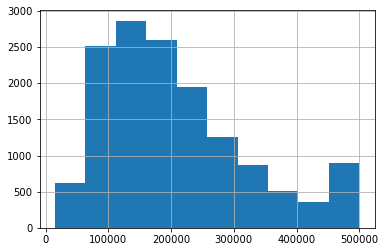

In [15]:
train["median_house_value"].hist()

Com isso, percebe-se uma concentração em aproximadamente US$150.000.

Vamos proceder criando uma matriz de correlação, relacionando todas as features:

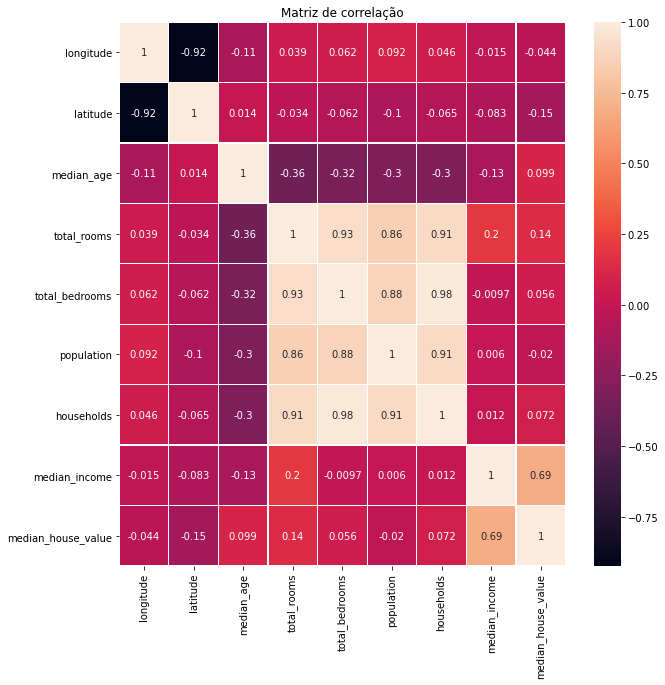

In [16]:
plt.figure(figsize=(10,10))
plt.title("Matriz de correlação")
sns.heatmap(train.corr(), annot=True, linewidths=0.2)

A partir desse heatmap, percebemos que a feature mais relacionada ao alvo é a renda média ("median_income"). Aparentemente, as variáveis de posição (latitude e longitude) não têm influência sobre as outras variáveis. Vamos convertê-las para uma só feature: a menor distância até as três maiores cidades da Califórnia: Los Angeles, São Francisco e São Diego.

Utilizando a biblioteca geopy, vamos definir uma função que calcula a distância de determinada casa até as três cidades, e retorna o menor valor encontrado:

In [17]:
coord_LA = (34.0522, -118.2437)
coord_SF = (37.7749, -122.4194)
coord_SD = (32.7157, -117.1611)

def dist_cidades(df):
    coord_casa = (df["latitude"], df["longitude"])
    df["dist_to_city"] = min(geodesic(coord_casa, coord_SF).km, geodesic(coord_casa, coord_LA).km, geodesic(coord_casa, coord_SD).km)
    
    return df

Agora vamos aplicar essa função ao dataframe de treino, substituindo latitude e longitude pela distância:

In [18]:
train = train.apply(dist_cidades, axis = 1)
train = train.drop(["latitude", "longitude"], axis = 1)

Além disso, a partir da matriz de correlação, podemos ver que as variáveis "total_rooms", "total_bedrooms", "population" e "household" têm uma ligação extrema entre si. Por isso, vamos adicionar uma média em relação a "households". Além disso, podemos adicionar a variável "bedrooms/rooms", uma vez que "total_bedrooms" e "total_rooms" têm alta correlação entre si, mas baixa com a variável alvo. Finalmente, podemos também criar as features "people/room" e "people/bedroom":

In [19]:
train["avg_rooms"] = train.total_rooms/train.households
train["avg_bedrooms"] = train.total_bedrooms/train.households
train["avg_population"] = train.population/train.households
train["bedrooms/rooms"] = train.total_bedrooms/train.total_rooms
train["people/room"] = train.population/train.total_rooms
train["people/bedroom"] = train.population/train.total_bedrooms

Se ainda não tiverem uma correlação significante com a variável alvo, podemos descartá-las.

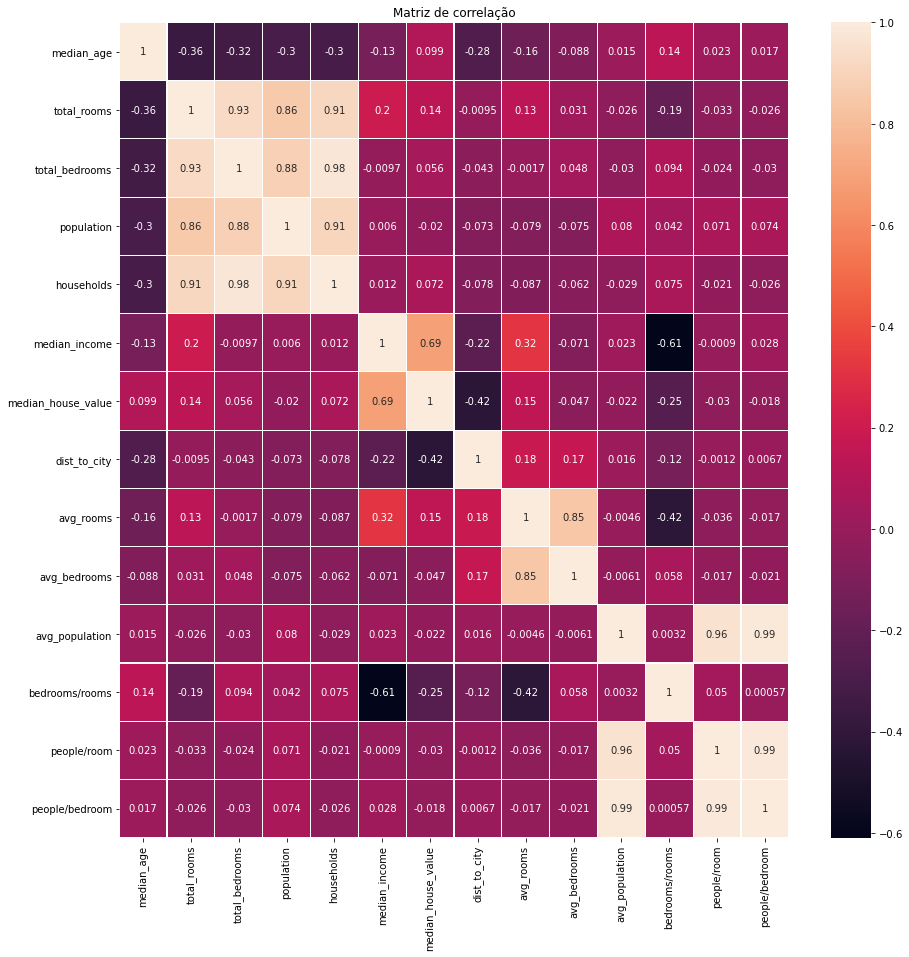

In [20]:
plt.figure(figsize=(15,15))
plt.title("Matriz de correlação")
sns.heatmap(train.corr(), annot=True, linewidths=0.2)

Observando a matriz, vemos que "people/room", "people/bedroom" e "avg_population" estão muito relacionadas, então podemos manter apenas uma delas. Além disso, temos que "total_rooms" é aproximadamente igual a "avg_rooms". O mesmo ocorre com "households" e "total_bedrooms"; "households" e "total_rooms".

Com isso, vamos remover "people/room", "avg_population", "avg_rooms", "total_bedrooms" e "total_rooms":

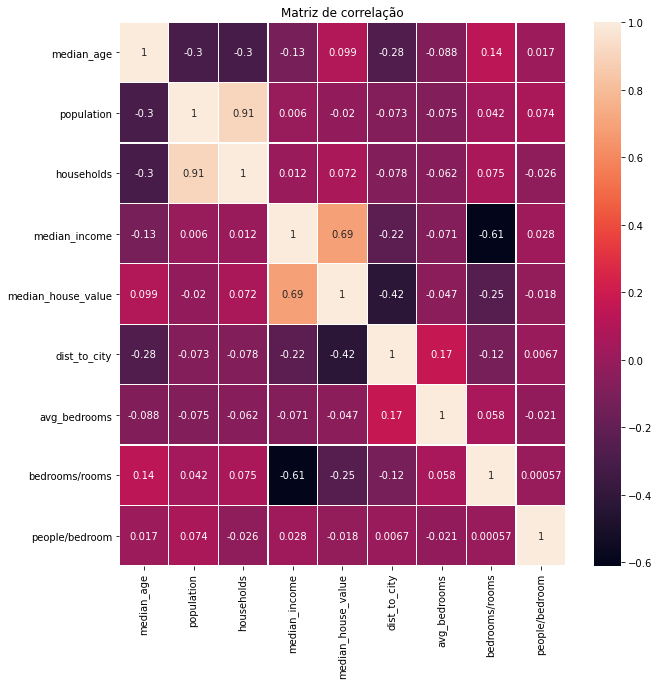

In [21]:
train = train.drop(["people/room", "avg_population", "avg_rooms", "total_bedrooms", "total_rooms"], axis = 1)
plt.figure(figsize=(10,10))
plt.title("Matriz de correlação")
sns.heatmap(train.corr(), annot=True, linewidths=0.2)

Definidas as variáveis auxiliares que serão utilizadas, vamos criá-las também para a base de teste:

In [22]:
test = test.apply(dist_cidades, axis = 1)
test["avg_bedrooms"] = test.total_bedrooms/test.households
test["bedrooms/rooms"] = test.total_bedrooms/test.total_rooms
test["people/bedroom"] = test.population/test.total_bedrooms

test = test.drop(["latitude", "longitude", "total_bedrooms", "total_rooms"], axis = 1)

Visualizando o início de cada tabela para conferir os atributos:

In [23]:
train.head()

,median_age,population,households,median_income,median_house_value,dist_to_city,avg_bedrooms,bedrooms/rooms,people/bedroom
0,27.0,451.0,150.0,34934.0,193800.0,140.308617,1.046667,0.191697,2.872611
1,48.0,1508.0,548.0,28983.0,129200.0,46.511604,1.093066,0.245693,2.517529
2,32.0,729.0,177.0,43000.0,151300.0,19.174143,1.073446,0.187008,3.836842
3,35.0,984.0,384.0,34167.0,198200.0,15.747283,1.164062,0.253977,2.201342
4,27.0,1462.0,479.0,26439.0,69100.0,163.137174,0.926931,0.213154,3.292793


In [24]:
test.head()

,median_age,population,households,median_income,dist_to_city,avg_bedrooms,bedrooms/rooms,people/bedroom
0,5.0,2440.0,736.0,79013.0,47.960483,1.120924,0.134738,2.957576
1,26.0,593.0,188.0,36667.0,54.042854,1.063830,0.173762,2.965000
2,34.0,1558.0,421.0,26903.0,159.134955,1.059382,0.184909,3.493274
3,16.0,956.0,472.0,25625.0,94.050076,1.103814,0.202173,1.834933
4,14.0,1140.0,369.0,47019.0,178.892800,0.962060,0.156595,3.211268


# 4. Aplicação dos modelos de Regressão:

Vamos normalizar o conjunto de treino, exceto a variável de classe, e vamos criar um conjunto de avaliação:

In [25]:
scaler = MinMaxScaler()
sel_col = ['median_age', 'population', 'households', 'median_income', 'dist_to_city', "avg_bedrooms", "bedrooms/rooms", "people/bedroom"]
trainScaled = scaler.fit_transform(train[sel_col])
X_train, X_test, Y_train, Y_test = train_test_split(trainScaled, train['median_house_value'], test_size=0.20)

Além disso, também devemos normalizar o dataset de teste, de modo que tenhamos entradas de ordens de grandeza equivalentes, condição necessária para classificação correta da variável de classe:

In [26]:
testScaled = scaler.fit_transform(test[sel_col])

Devemos definir uma função para calcular o "root mean squared log error", que será usado no Leaderboard:

In [27]:
def rmsle(y_test,y_pred):
    return np.sqrt(np.mean((np.log(np.abs(y_pred)+1) - np.log(np.abs(y_test)+1))**2))

Junto a um sistema de scoring que leva em conta esse erro:

In [28]:
scorer = make_scorer(rmsle, greater_is_better=False)

## 4.1. Implementação de Regressão Linear:

Vamos otimizar os hiperparâmetros para o menor RMSLE utilizando o GridSearch:

In [29]:
LR = LinearRegression()
LR.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

Esse regressor tem um score de:

In [30]:
LR_score = np.mean(cross_val_score(LR, X_train, Y_train, cv = 10))
LR_score

0.5986203229332518

In [31]:
grid_params_LR = {"fit_intercept":[True, False],"normalize":[True,False]}
grid_LR = GridSearchCV(LR,grid_params_LR,cv=10,scoring=scorer)

In [32]:
grid_LR.fit(X_train, Y_train)
print(grid_LR.best_estimator_)

LinearRegression(fit_intercept=False, normalize=True)


Podemos calcular o erro do melhor estimador comparando o resultado gerado pelo conjunto de teste com o "gabarito" do conjunto de avaliação:

In [33]:
LR = grid_LR.best_estimator_
LR.fit(X_train, Y_train)
Y_pred = LR.predict(X_test)
LR_RMSLE = rmsle(Y_pred, Y_test)
print("RMSLE:", LR_RMSLE)

RMSLE: 0.3912825315393159


## 4.2. Implementação de Regressão kNN:

Vamos buscar otimizar os hiperparâmetros por meio do GridSearch:

In [34]:
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Esse regressor tem score de:

In [35]:
knn_score = np.mean(cross_val_score(knn, X_train, Y_train, cv = 10))
knn_score

0.6321009840938374

In [36]:
grid_params_knn = {"n_neighbors":[i for i in range(1,31)],"weights":["uniform","distance"],"p":[1,2]}
grid_knn = GridSearchCV(knn,grid_params_knn,cv=10)

In [37]:
grid_knn.fit(X_train,Y_train)
print(grid_knn.best_estimator_)

KNeighborsRegressor(n_neighbors=17, p=1, weights='distance')


Assim, escolhemos o regressor com melhor pontuação:

In [38]:
knn = grid_knn.best_estimator_
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
knn_RMSLE = rmsle(Y_pred, Y_test)
print("RMSLE:", knn_RMSLE)

RMSLE: 0.32535731216819697


## 4.3. Implementação de Regressão RIDGE:

Novamente, utilizaremos o GridSearch para encontrar os melhores hiperparâmetros:

In [39]:
ridge = Ridge()
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

Esse regressor tem score de:

In [40]:
ridge_score = np.mean(cross_val_score(ridge, X_train, Y_train, cv = 10))
ridge_score

0.610584914312281

In [41]:
grid_params_ridge = {"alpha":np.linspace(0.5,10.5,101).tolist()}
grid_ridge = GridSearchCV(ridge,grid_params_ridge,cv=10,scoring=scorer)

In [42]:
grid_ridge.fit(X_train, Y_train)
print(grid_ridge.best_estimator_)

Ridge(alpha=2.9000000000000004)


Logo, o regressor RIDGE que vamos escolher tem score de:

In [43]:
ridge = grid_ridge.best_estimator_
ridge.fit(X_train, Y_train)
Y_pred = ridge.predict(X_test)
ridge_RMSLE = rmsle(Y_pred, Y_test)
print("RMSLE:", ridge_RMSLE)

RMSLE: 0.3759283614829732


## 4.4. Implementação de Regressão LASSO:

O processo a ser seguido é totalmente análogo ao realizado para as outras duas regressões:

In [44]:
lasso = Lasso()
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

Esse regressor tem score de:

In [45]:
lasso_score = np.mean(cross_val_score(lasso, X_train, Y_train, cv = 10))
lasso_score

0.6014587460356668

In [46]:
grid_params_lasso = {"alpha":np.linspace(0.5,5.5,51).tolist(),"normalize":[True,False]}
grid_lasso = GridSearchCV(lasso,grid_params_lasso,cv=10,scoring=scorer)

In [47]:
grid_lasso.fit(X_train, Y_train)
print(grid_lasso.best_estimator_)

Lasso(alpha=4.4, normalize=True)


Portanto temos:

In [48]:
lasso = grid_lasso.best_estimator_
lasso.fit(X_train, Y_train)
Y_pred = lasso.predict(X_test)
lasso_RMSLE = rmsle(Y_pred, Y_test)
print("RMSLE:", lasso_RMSLE)

RMSLE: 0.37608688161579906


# 6. Exportação das predições:

Devemos escolher o modelo que apresentou menor RMSLE, mas que ainda tenha um score razoável. Temos a seguinte tabela:

In [49]:
resultados = {"Regressor": ["LR", "kNN", "Ridge", "LASSO"],"RMSLE":[LR_RMSLE, knn_RMSLE, ridge_RMSLE, lasso_RMSLE], "Score":[LR_score, knn_score, ridge_score, lasso_score]}
table = pd.DataFrame(resultados, columns =  ["Regressor", "RMSLE", "Score"])
print(table)

  Regressor     RMSLE     Score
0        LR  0.391283  0.598620
1       kNN  0.325357  0.632101
2     Ridge  0.375928  0.610585
3     LASSO  0.376087  0.601459


Logo, vemos que o regressor kNN é o que apresentou menor RMSLE e maior Score, o que não é de surpreender. A regressão kNN é baseada em otimizar o hiperparâmetro k para conseguir o menor RMSE e, consequentemente, o menor RMSLE.

Treinando-o para a base de dados:

In [50]:
knn.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=17, p=1, weights='distance')

Agora, devemos criar um arquivo csv com as predições para a base de teste, no formato pedido:

In [51]:
YtestPred = knn.predict(test)
predict = pd.DataFrame(testId)
predict["median_house_value"] = YtestPred
predict.to_csv("pred_knn.csv", index = False, index_label = 'Id')